In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/tmp/ipykernel_1060054/82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import seaborn as sns
from pyDOE import lhs
import random
import os
import time

plt.rcParams.update({'font.size':18})

In [3]:
def seed_torch(seed=1024):
#     random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
#     torch.use_deterministic_algorithms(True)  # 有检查操作，看下文区别
 
seed_torch(314)

## 检验数据

In [4]:
# 导入数据
data = scipy.io.loadmat('cylinder_nektar_wake.mat')
X_star = data['X_star'] # 5000,2
t_star = data['t']           # 200,1
U_star = data['U_star'] # 5000,2,200
# 压力p：p(x,y,z,t)
p_star = data['p_star'] # 5000,200

N = X_star.shape[0]
T = t_star.shape[0]

# 平铺
# X,Y分别的坐标
XX = np.tile(X_star[:,0:1], (1,T)) # N,T(5000,200)
YY = np.tile(X_star[:,1:2], (1,T)) # N,T(5000,200)
# 时间t
TT = np.tile(t_star, (1,N)).T # N,T(5000,200)

# 沿x,y方向的速度：u(x,y,z,t)、v(x,y,z,t)
UU = U_star[:,0,:] # N,T(5000,200)
VV = U_star[:,1,:] # N,T(5000,200)
# 压力p：p(x,y,z,t)
PP = p_star # N,T(5000,200)

x = XX.flatten()[:, None]  # NT x 1
y = YY.flatten()[:, None]  # NT x 1
t = TT.flatten()[:, None]  # NT x 1

u = UU.flatten()[:, None]  # NT x 1
v = VV.flatten()[:, None]  # NT x 1
p = PP.flatten()[:, None]  # NT x 1

(50, 100)
(50, 100)


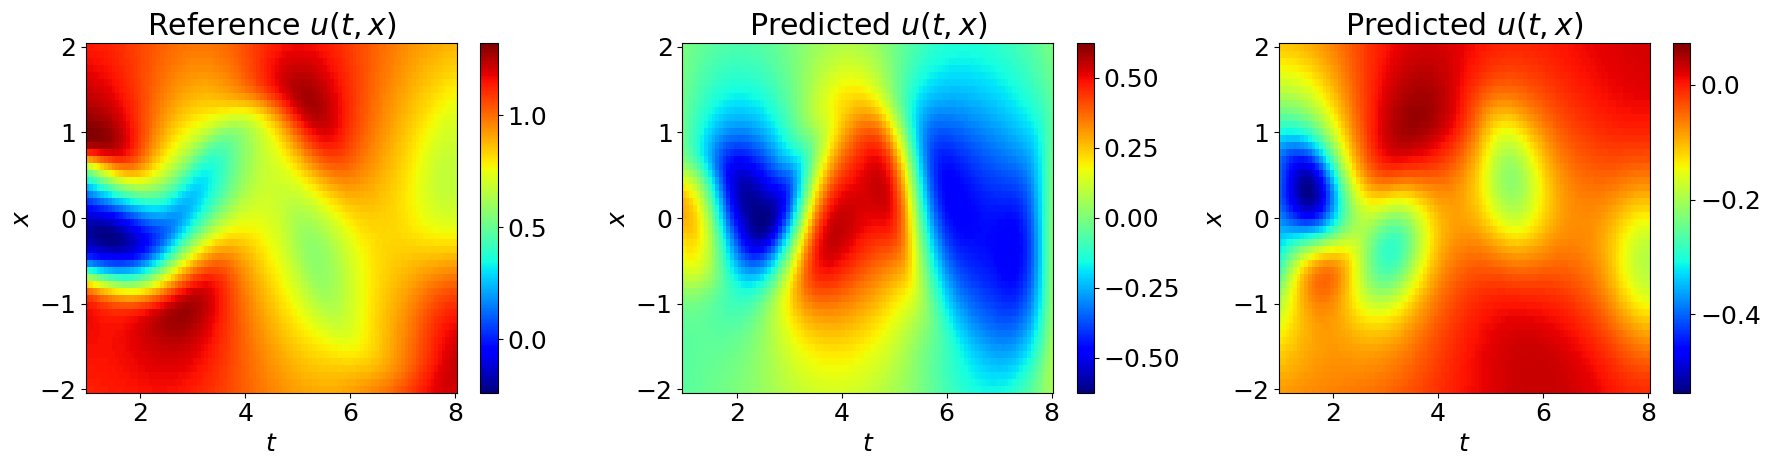

In [5]:
lb = X_star.min(0)
ub = X_star.max(0)
# nn = 1000
x_pic = np.linspace(lb[0], ub[0], 100)
y_pic = np.linspace(lb[1], ub[1], 50)
xx, yy = np.meshgrid(x_pic,y_pic)

print(xx.shape)
print(yy.shape)

NS_u = U_star[:,0,100]
NS_v = U_star[:,1,100]
NS_p = p_star[:,100]

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
# plt.pcolor(xx, yy, u_true.reshape(xx.shape), cmap='jet')
plt.pcolor(xx, yy, NS_u.reshape(xx.shape), cmap='jet')
plt.colorbar()
plt.clim([u.min(),u.max()])
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Reference $u(t,x)$')
plt.tight_layout()

plt.subplot(1, 3, 2)
# plt.pcolor(xx, yy, u_pred.reshape(xx.shape), cmap='jet')
plt.pcolor(xx, yy, NS_v.reshape(xx.shape), cmap='jet')
plt.colorbar()
plt.clim([v.min(),v.max()])
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Predicted $u(t,x)$')
plt.tight_layout()

plt.subplot(1, 3, 3)
# plt.pcolor(xx, yy, u_pred.reshape(xx.shape), cmap='jet')
plt.pcolor(xx, yy, NS_p.reshape(xx.shape), cmap='jet')
plt.colorbar()
plt.clim([p.min(),p.max()])
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Predicted $u(t,x)$')
plt.tight_layout()

## 超参数

In [6]:
domain = (x.min(),x.max(),y.min(),y.max(),t.min(),t.max())
xmin , xmax ,ymin,ymax,tmin,tmax = domain
backbone_layers = [3] + [20]*8 + [2]
nn_lam_layers = [3] +[20]*8 + [2]
N_train = 5000
adam_iters = 50000
# adam_iters = 200000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = r'./model'
train_info_path = r'./'
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [7]:
ymax

2.0

## 数据集生成

In [8]:
class DatasetNS:
    def __init__(self, domain):
        self.domain = domain

    def train_data(self, N_train, verbose=None):
        xmin, xmax, ymin, ymax, tmin, tmax = domain
        
        idx = np.random.choice(N * T, N_train, replace=False)
        x_train = x[idx, :]
        y_train = y[idx, :]
        t_train = t[idx, :]
        u_train = u[idx, :]
        v_train = v[idx, :]
        p_train = p[idx, :]

        return x_train, y_train, t_train, u_train, v_train, p_train
    

dataset = DatasetNS(domain)
x_train, y_train, t_train, u_train, v_train, p_train = dataset.train_data(N_train)
print(x_train.shape, y_train.shape, t_train.shape, u_train.shape, v_train.shape, p_train.shape)

(5000, 1) (5000, 1) (5000, 1) (5000, 1) (5000, 1) (5000, 1)


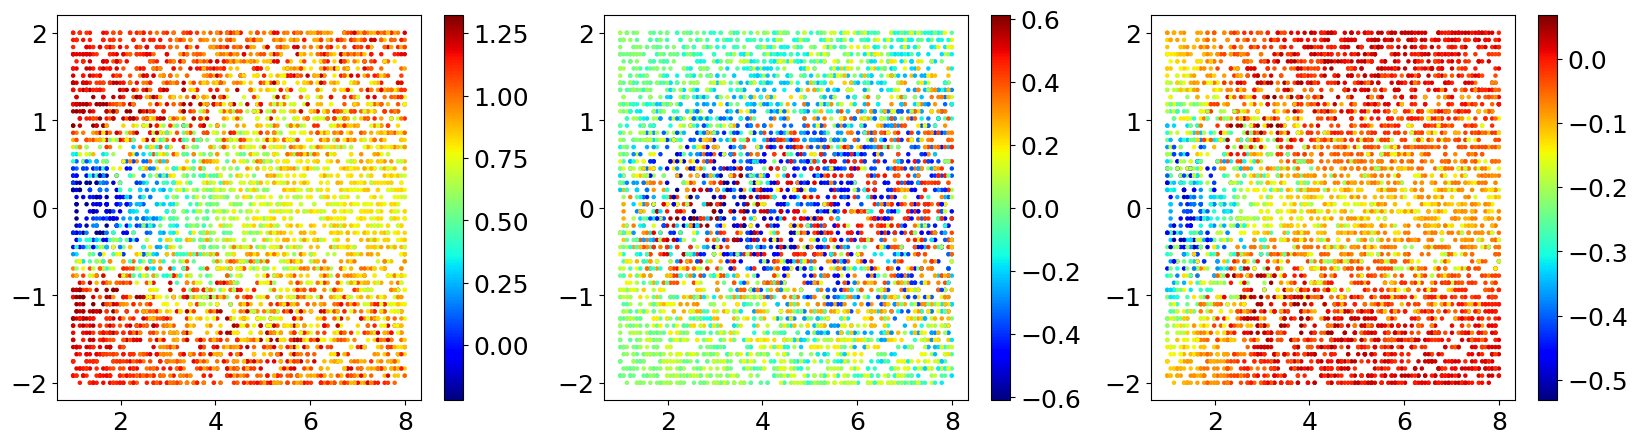

In [9]:
# 随即采样真实数据
fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(1, 3)

plt.subplot(1,3,1)
plt.scatter(x_train, y_train, c=u_train, s=5, cmap='jet')
plt.colorbar()

plt.subplot(1,3,2)
plt.scatter(x_train, y_train, c=v_train, s=5, cmap='jet')
plt.colorbar()

plt.subplot(1,3,3)
plt.scatter(x_train, y_train, c=p_train, s=5, cmap='jet')
plt.colorbar()

## 主干网络

In [10]:
class MLP(nn.Module):
    def __init__(self, mlp_layers):
        super(MLP, self).__init__()
        
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            layer = nn.Sequential()
            layer.add_module(f'fc{i}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            layer.add_module(f'act{i}', nn.Tanh())
            self.model.add_module(f'layer{i}', layer)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'layer{len(mlp_layers)-2}', last_layer)
        
#         for param in self.parameters():
#             if len(param.shape) > 1:
#                 nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        return self.model(X)

    
    
backbone = MLP(backbone_layers)
nn_lam = MLP(nn_lam_layers)

In [11]:
nn_lam

MLP(
  (model): Sequential(
    (layer0): Sequential(
      (fc0): Linear(in_features=3, out_features=20, bias=True)
      (act0): Tanh()
    )
    (layer1): Sequential(
      (fc1): Linear(in_features=20, out_features=20, bias=True)
      (act1): Tanh()
    )
    (layer2): Sequential(
      (fc2): Linear(in_features=20, out_features=20, bias=True)
      (act2): Tanh()
    )
    (layer3): Sequential(
      (fc3): Linear(in_features=20, out_features=20, bias=True)
      (act3): Tanh()
    )
    (layer4): Sequential(
      (fc4): Linear(in_features=20, out_features=20, bias=True)
      (act4): Tanh()
    )
    (layer5): Sequential(
      (fc5): Linear(in_features=20, out_features=20, bias=True)
      (act5): Tanh()
    )
    (layer6): Sequential(
      (fc6): Linear(in_features=20, out_features=20, bias=True)
      (act6): Tanh()
    )
    (layer7): Sequential(
      (fc7): Linear(in_features=20, out_features=20, bias=True)
      (act7): Tanh()
    )
    (layer8): Sequential(
      (fc8)

## PINN模型

In [12]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True, 
                               retain_graph=True)

In [13]:
"""PINN模型"""
class PINNNS(nn.Module):
    def __init__(self, backbone, nn_lam, mu=None, sigma=None):
        super(PINNNS, self).__init__()
        self.backbone = backbone
        self.nn_lam = nn_lam
        self.lam1 = torch.tensor([0.0], requires_grad=True)
        self.lam2 = torch.tensor([0.0], requires_grad=True)

        self.lam1 = torch.nn.Parameter(self.lam1)
        self.lam2 = torch.nn.Parameter(self.lam2)

        self.backbone = MLP(backbone_layers).to(device)
        self.nn_lam = MLP(nn_lam_layers).to(device)

        self.backbone.register_parameter('lam1', self.lam1)
        self.backbone.register_parameter('lam2', self.lam2)

        self.nn_lam.register_parameter('lam1', self.lam1)
        self.nn_lam.register_parameter('lam2', self.lam2)
        
        self.dataset = DatasetNS(domain)
        
#         self.bound1 = 1.
#         self.bound2 = 0.01
        
        if mu is not None and sigma is not None:
            self.is_inputs_normalization = True
            self.mu = mu
            self.sigma = sigma
            print(f'forward with normalization, mu={self.mu.tolist()}, sigma={self.sigma.tolist()}')
        else:
            self.is_inputs_normalization = False

    def forward(self,X_res, u_star, v_star):
        f_u, f_v, u, v, p = self.net_NS(X_res)
        loss_u_data = torch.mean(f_u ** 2)
        loss_v_data = torch.mean(f_v ** 2)
        loss_u_res = torch.mean((u_star - u) ** 2)
        loss_v_res = torch.mean((v_star - v) ** 2)

        return loss_u_data, loss_v_data, loss_u_res, loss_v_res
    
    def update_train_data(self):
        """更新采样点"""
        self.x, self.y, self.t, self.u, self.v, self.p = self.dataset.train_data(N_train)
        
        
    def net_u(self,X):
        if self.is_inputs_normalization == True:
            X = (X - self.mu) / self.sigma
        return self.backbone(X)
        # return self.backbone(X_res)

    def net_NS(self,X_res):
        # X_res = np.concatenate([x, y, t], 1)
        # X_res = X_res.detach().numpy()
        X_res.requires_grad_(True)
        
        x = X_res[:,0]
        y = X_res[:,1]
        t = X_res[:,2]
        
#         x.requires_grad_(True)
#         y.requires_grad_(True)
#         t.requires_grad_(True)

        pred = self.net_u(X_res)
        psi = pred[:,[0]].reshape(-1, 1)
        p = pred[:,[1]].reshape(-1, 1)
        
        psi.requires_grad_(True)
        p.requires_grad_(True)
#         u_x = grad(u, x)[0]
#         u_y = grad(u, y)[0]
#         u_t = grad(u, t)[0]
#         u_xx = grad(u_x, x)[0]
#         u_yy = grad(u_y, y)[0]

#         v_x = grad(v, x)[0]
#         v_y = grad(v, y)[0]
#         v_t = grad(v, t)[0]
#         v_xx = grad(v_x, x)[0]
#         v_yy = grad(v_y, y)[0]

#         p_x = grad(p, x)[0]
#         p_y = grad(p, y)[0]

        grad_psi = grad(psi,X_res)[0]
        u = grad_psi[:, [1]]
        v = - grad_psi[:, [0]]
#         标记

        grad_u = grad(u, X_res)[0]
        u_x = grad_u[:, [0]]
        u_y = grad_u[:, [1]]
        u_t = grad_u[:, [2]]
        u_xx = grad(u_x, X_res)[0][:, [0]]
        u_yy = grad(u_y, X_res)[0][:, [1]]
        
        grad_v = grad(v, X_res)[0]
        v_x = grad_v[:, [0]]
        v_y = grad_v[:, [1]]
        v_t = grad_v[:, [2]]
        v_xx = grad(v_x, X_res)[0][:, [0]]
        v_yy = grad(v_y, X_res)[0][:, [1]]
        
        grad_p = grad(p, X_res)[0]
        p_x = grad_p[:, [0]]
        p_y = grad_p[:, [1]]

        lam1 = self.lam1
        lam2 = self.lam2

        f_u = u_t + lam1 * (u*u_x + v*u_y) + p_x - lam2 * (u_xx + u_yy)
        f_v = v_t + lam1 * (u*v_x + v*v_y) + p_y - lam2 * (v_xx + v_yy)
        return f_u, f_v, u, v, p

pinn = PINNNS(backbone, nn_lam)

## Adam优化

In [14]:
"""Adam优化"""
dataset = DatasetNS(domain)  # 生成训练数据
x_train, y_train, t_train, u_train, v_train, p_train = dataset.train_data(N_train)
x_train = torch.from_numpy(x_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
t_train = torch.from_numpy(t_train).float().to(device)
u_train = torch.from_numpy(u_train).float().to(device)
v_train = torch.from_numpy(v_train).float().to(device)
p_train = torch.from_numpy(p_train).float().to(device)

X_res = torch.cat([x_train,y_train,t_train], dim=1)
# X_res = np.concatenate([x, y, t],1)
# X_res = torch.tensor(X_res)
mu = X_res.mean(dim=0)
sigma = X_res.std(dim=0)  # 求样本标准差

backbone = MLP(backbone_layers)  # 主干网络
nn_lam = MLP(nn_lam_layers)  # 参数网络 lambda1,2
pinn = PINNNS(backbone, nn_lam, mu, sigma).to(device)

optimizer_adam = optim.Adam(pinn.backbone.parameters(), lr=1e-3)
optimizer_adam_lam = optim.Adam(pinn.nn_lam.parameters(), lr=1e-3)

lr_sche = optim.lr_scheduler.ExponentialLR(optimizer_adam, gamma=0.8)  # 指数衰减学习率
lr_sche_lam = optim.lr_scheduler.ExponentialLR(optimizer_adam_lam, gamma=0.9)
logger = {
    "loss": [],
    "loss_u_res": [],
    "loss_v_res": [],
    "loss_u_data": [],
    "loss_v_data": [],
    "iter": [],
    "mu": mu,
    "sigma": sigma
}
best_loss = 1e9

# 训练
start_time = time.time()
for it in range(adam_iters):
    # 计算loss并更新网络 -------
    pinn.train()
    pinn.zero_grad()

    loss_u_data, loss_v_data,loss_u_res, loss_v_res = pinn(X_res,u_train,v_train)
    # loss = 100 * loss_res + 100 * loss_data
    loss = (loss_u_data + loss_v_data + loss_u_res + loss_v_res) * 100

    loss.backward()
    optimizer_adam.step()
    optimizer_adam_lam.step()
    # 计算loss并更新网络 -------

    if (it + 1) % 100 == 0:
        # 保存loss信息
        pinn.train(False)
        loss_u_data_valid, loss_v_data_valid, loss_u_res_valid, loss_v_res_valid = pinn(X_res,u_train,v_train)
        loss_valid = loss_u_data_valid + loss_v_data_valid + loss_u_res_valid + loss_v_res_valid

        logger["loss"].append(loss_valid.item())
        logger["loss_u_res"].append(loss_u_res_valid.item())
        logger["loss_v_res"].append(loss_v_res_valid.item())
        logger["loss_u_data"].append(loss_u_data_valid.item())
        logger["loss_v_data"].append(loss_v_data_valid.item())
        logger["iter"].append(it + 1)

        # 保存训练loss最低的模型
        if loss_valid.item() < best_loss:
            model_state = {'iter': it + 1, 'backbone_state': pinn.backbone.state_dict(),
                           'nn_lam_state': pinn.nn_lam.state_dict()}
            torch.save(model_state, os.path.join(model_path, 'pinn_adam.pth'))
            best_loss = loss_valid.item()

        if (it + 1) % 500 == 0:
            # 保存并打印训练日志
            info = f'Iter # {it + 1:6d}/{adam_iters}\t' + \
                   f'loss:{loss.item():.2e}, loss_u_r:{loss_u_res.item():.2e}, loss_v_r:{loss_v_res.item():.2e}, loss_u_d:{loss_u_data.item():.2e} ,loss_v_d:{loss_v_data.item():.2e} ' + \
                   f'Valid # loss:{loss_valid.item():.2e}, loss_r:{loss_u_res_valid.item():.2e}, loss_r:{loss_v_res_valid.item():.2e}, loss_u_d:{loss_u_data_valid.item():.2e}, loss_v_d:{loss_v_data_valid.item():.2e}'
            with open(train_info_path + 'train_info.txt', 'a') as f:
                f.write(info + '\n')
            print(info)
        pinn.update_train_data()

        # 衰减学习率
        if (it + 1) % 4000 == 0:
            lr_sche.step()
            lr_sche_lam.step()

forward with normalization, mu=[4.480413913726807, -0.01456326525658369, 9.955120086669922], sigma=[2.046708345413208, 1.173058271408081, 5.741751194000244]
Iter #    500/50000	loss:9.58e+00, loss_u_r:2.51e-02, loss_v_r:7.07e-02, loss_u_d:1.64e-05 ,loss_v_d:1.34e-05 Valid # loss:9.58e-02, loss_r:2.51e-02, loss_r:7.07e-02, loss_u_d:1.64e-05, loss_v_d:1.34e-05
Iter #   1000/50000	loss:9.22e+00, loss_u_r:2.35e-02, loss_v_r:6.86e-02, loss_u_d:2.75e-05 ,loss_v_d:1.15e-04 Valid # loss:9.18e-02, loss_r:2.30e-02, loss_r:6.87e-02, loss_u_d:2.87e-05, loss_v_d:1.15e-04
Iter #   1500/50000	loss:9.05e+00, loss_u_r:2.23e-02, loss_v_r:6.79e-02, loss_u_d:4.81e-05 ,loss_v_d:2.01e-04 Valid # loss:9.05e-02, loss_r:2.23e-02, loss_r:6.79e-02, loss_u_d:4.82e-05, loss_v_d:2.02e-04
Iter #   2000/50000	loss:8.92e+00, loss_u_r:2.21e-02, loss_v_r:6.65e-02, loss_u_d:9.91e-05 ,loss_v_d:4.98e-04 Valid # loss:8.92e-02, loss_r:2.21e-02, loss_r:6.65e-02, loss_u_d:9.93e-05, loss_v_d:4.99e-04
Iter #   2500/50000	loss:8.

Iter #  20500/50000	loss:1.94e+00, loss_u_r:5.29e-03, loss_v_r:9.68e-03, loss_u_d:2.06e-03 ,loss_v_d:2.34e-03 Valid # loss:1.93e-02, loss_r:5.37e-03, loss_r:9.69e-03, loss_u_d:2.05e-03, loss_v_d:2.21e-03
Iter #  21000/50000	loss:1.91e+00, loss_u_r:5.36e-03, loss_v_r:9.56e-03, loss_u_d:2.05e-03 ,loss_v_d:2.15e-03 Valid # loss:1.91e-02, loss_r:5.21e-03, loss_r:9.54e-03, loss_u_d:2.05e-03, loss_v_d:2.31e-03
Iter #  21500/50000	loss:1.88e+00, loss_u_r:5.14e-03, loss_v_r:9.42e-03, loss_u_d:2.03e-03 ,loss_v_d:2.23e-03 Valid # loss:1.88e-02, loss_r:5.20e-03, loss_r:9.42e-03, loss_u_d:2.03e-03, loss_v_d:2.16e-03
Iter #  22000/50000	loss:1.86e+00, loss_u_r:5.10e-03, loss_v_r:9.29e-03, loss_u_d:2.01e-03 ,loss_v_d:2.19e-03 Valid # loss:1.86e-02, loss_r:5.13e-03, loss_r:9.30e-03, loss_u_d:2.02e-03, loss_v_d:2.15e-03
Iter #  22500/50000	loss:1.97e+00, loss_u_r:5.68e-03, loss_v_r:9.16e-03, loss_u_d:2.09e-03 ,loss_v_d:2.78e-03 Valid # loss:2.04e-02, loss_r:7.14e-03, loss_r:9.29e-03, loss_u_d:2.08e-03

Iter #  41000/50000	loss:1.27e+00, loss_u_r:3.36e-03, loss_v_r:5.71e-03, loss_u_d:1.93e-03 ,loss_v_d:1.66e-03 Valid # loss:1.27e-02, loss_r:3.37e-03, loss_r:5.70e-03, loss_u_d:1.93e-03, loss_v_d:1.66e-03
Iter #  41500/50000	loss:1.26e+00, loss_u_r:3.34e-03, loss_v_r:5.67e-03, loss_u_d:1.94e-03 ,loss_v_d:1.67e-03 Valid # loss:1.26e-02, loss_r:3.40e-03, loss_r:5.67e-03, loss_u_d:1.92e-03, loss_v_d:1.63e-03
Iter #  42000/50000	loss:1.26e+00, loss_u_r:3.41e-03, loss_v_r:5.65e-03, loss_u_d:1.90e-03 ,loss_v_d:1.63e-03 Valid # loss:1.26e-02, loss_r:3.38e-03, loss_r:5.62e-03, loss_u_d:1.94e-03, loss_v_d:1.67e-03
Iter #  42500/50000	loss:1.26e+00, loss_u_r:3.33e-03, loss_v_r:5.60e-03, loss_u_d:1.93e-03 ,loss_v_d:1.69e-03 Valid # loss:1.25e-02, loss_r:3.39e-03, loss_r:5.57e-03, loss_u_d:1.92e-03, loss_v_d:1.63e-03
Iter #  43000/50000	loss:1.24e+00, loss_u_r:3.29e-03, loss_v_r:5.52e-03, loss_u_d:1.92e-03 ,loss_v_d:1.63e-03 Valid # loss:1.24e-02, loss_r:3.29e-03, loss_r:5.52e-03, loss_u_d:1.92e-03

In [15]:
np.save("./logger.npy", logger)
model_state

{'iter': 50000,
 'backbone_state': OrderedDict([('lam1', tensor([0.9275], device='cuda:0')),
              ('lam2', tensor([0.0165], device='cuda:0')),
              ('model.layer0.fc0.weight',
               tensor([[ 0.2837,  0.2381, -0.7329],
                       [-0.0469,  0.1462,  0.8371],
                       [ 0.4691,  0.3990, -0.2557],
                       [ 0.5653,  0.7351, -0.9811],
                       [ 0.5180,  0.1416, -0.0976],
                       [-0.1401, -0.7720, -0.0544],
                       [ 0.3698,  0.5810, -0.5033],
                       [ 0.2258, -0.1398, -0.5261],
                       [ 0.3619,  0.0954,  0.1070],
                       [ 0.4235,  0.1071, -0.7273],
                       [-0.2010,  0.1987,  0.3095],
                       [-0.0396, -0.1751,  0.1135],
                       [ 0.3371, -0.6525, -0.2565],
                       [-0.3379,  0.3103,  0.1751],
                       [-0.5366,  0.2467,  0.5267],
                       [-0

# 无噪声LBFGS

In [16]:
"""LBFGS训练"""
start_time = time.time()

dataset = DatasetNS(domain)  # 生成训练数据
x_train, y_train, t_train, u_train, v_train, p_train = dataset.train_data(N_train)
x_train = torch.from_numpy(x_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
t_train = torch.from_numpy(t_train).float().to(device)
u_train = torch.from_numpy(u_train).float().to(device)
v_train = torch.from_numpy(v_train).float().to(device)
p_train = torch.from_numpy(p_train).float().to(device)

# X_res = np.concatenate([x, y, t],1)
# X_res = torch.tensor(X_res)
X_res = torch.cat([x_train,y_train,t_train], dim=1)
mu = X_res.mean(dim=0)
sigma = X_res.std(dim=0)  # 求样本标准差

backbone = MLP(backbone_layers)  # 主干网络
nn_lam = MLP(nn_lam_layers)  # 参数网络 lambda1,2
pinn = PINNNS(backbone, nn_lam, mu, sigma).to(device)

model_state = torch.load(os.path.join(model_path, 'pinn_adam.pth'))
pinn.backbone.load_state_dict(model_state['backbone_state'])
pinn.nn_lam.load_state_dict(model_state['nn_lam_state'])

optimizer_lbfgs = optim.LBFGS(pinn.backbone.parameters(), max_iter=50000, line_search_fn="strong_wolfe",tolerance_grad=1e-5)
optimizer_lbfgs_lam = optim.LBFGS(pinn.nn_lam.parameters(), max_iter=50000, line_search_fn="strong_wolfe",tolerance_grad=1e-5)

loss_log_lbfgs = []
it = 0
with open(train_info_path + 'train_info.txt', 'a') as f:
    f.write('Training by LBFGS:\n')


def closure():
    global it
    pinn.zero_grad()
    loss_u_data,loss_v_data,loss_u_res,loss_v_res = pinn(X_res, u_train, v_train)
    loss = (loss_u_data + loss_v_data + loss_u_res + loss_v_res) *100
    loss.backward()
    it = it + 1
    loss_log_lbfgs.append(loss.item())
    if (it + 1) % 100 == 0:
        info = f'Iter # {it + 1:4d}\ttime:{time.time() - start_time:.1f}\t' + f'loss:{loss.item():.2e}, loss_u_r:{loss_u_res.item():.2e}, loss_v_r:{loss_v_res.item():.2e}, loss_u_d:{loss_u_data.item():2e}, loss_v_d:{loss_v_data.item():2e}'
        with open(train_info_path + 'train_info.txt', 'a') as f:
            f.write(info + '\n')
        print(info)
    return loss

optimizer_lbfgs.step(closure)
optimizer_lbfgs_lam.step(closure)

model_state = {'backbone_state': pinn.backbone.state_dict(), 'nn_lam_state': pinn.nn_lam.state_dict()}
backbone_path = os.path.join(model_path, f'pinn_lbfgs.pth')
torch.save(model_state, backbone_path)

forward with normalization, mu=[4.538040637969971, 0.016114283353090286, 9.939579010009766], sigma=[2.036494255065918, 1.1805088520050049, 5.820093631744385]
Iter #  100	time:3.5	loss:1.17e+00, loss_u_r:3.41e-03, loss_v_r:4.85e-03, loss_u_d:1.861413e-03, loss_v_d:1.619634e-03
Iter #  200	time:7.1	loss:1.13e+00, loss_u_r:3.24e-03, loss_v_r:4.63e-03, loss_u_d:1.829413e-03, loss_v_d:1.566162e-03
Iter #  300	time:10.8	loss:1.09e+00, loss_u_r:3.08e-03, loss_v_r:4.40e-03, loss_u_d:1.887638e-03, loss_v_d:1.533837e-03
Iter #  400	time:14.4	loss:1.06e+00, loss_u_r:3.02e-03, loss_v_r:4.21e-03, loss_u_d:1.895865e-03, loss_v_d:1.478887e-03
Iter #  500	time:18.1	loss:1.04e+00, loss_u_r:3.00e-03, loss_v_r:4.10e-03, loss_u_d:1.839741e-03, loss_v_d:1.435250e-03
Iter #  600	time:21.7	loss:1.01e+00, loss_u_r:2.87e-03, loss_v_r:3.94e-03, loss_u_d:1.824726e-03, loss_v_d:1.440495e-03
Iter #  700	time:25.4	loss:9.77e-01, loss_u_r:2.76e-03, loss_v_r:3.75e-03, loss_u_d:1.838626e-03, loss_v_d:1.424500e-03
Iter

Iter # 6800	time:248.3	loss:2.40e-01, loss_u_r:6.42e-04, loss_v_r:7.88e-04, loss_u_d:5.085990e-04, loss_v_d:4.614493e-04
Iter # 6900	time:252.0	loss:2.32e-01, loss_u_r:6.21e-04, loss_v_r:7.41e-04, loss_u_d:5.055156e-04, loss_v_d:4.525174e-04
Iter # 7000	time:255.6	loss:2.25e-01, loss_u_r:6.10e-04, loss_v_r:7.13e-04, loss_u_d:4.892673e-04, loss_v_d:4.395306e-04
Iter # 7100	time:259.3	loss:2.19e-01, loss_u_r:6.06e-04, loss_v_r:6.79e-04, loss_u_d:4.819711e-04, loss_v_d:4.242295e-04
Iter # 7200	time:262.9	loss:2.13e-01, loss_u_r:5.81e-04, loss_v_r:6.50e-04, loss_u_d:4.754449e-04, loss_v_d:4.248407e-04
Iter # 7300	time:266.6	loss:2.08e-01, loss_u_r:5.67e-04, loss_v_r:6.20e-04, loss_u_d:4.696681e-04, loss_v_d:4.216576e-04
Iter # 7400	time:270.2	loss:2.02e-01, loss_u_r:5.49e-04, loss_v_r:5.92e-04, loss_u_d:4.584969e-04, loss_v_d:4.165178e-04
Iter # 7500	time:273.9	loss:1.96e-01, loss_u_r:5.30e-04, loss_v_r:5.71e-04, loss_u_d:4.434994e-04, loss_v_d:4.158151e-04
Iter # 7600	time:277.5	loss:1.91

Iter # 13600	time:496.6	loss:6.38e-02, loss_u_r:1.59e-04, loss_v_r:1.66e-04, loss_u_d:1.749954e-04, loss_v_d:1.378717e-04
Iter # 13700	time:500.2	loss:6.30e-02, loss_u_r:1.57e-04, loss_v_r:1.64e-04, loss_u_d:1.721500e-04, loss_v_d:1.363200e-04
Iter # 13800	time:503.9	loss:6.22e-02, loss_u_r:1.55e-04, loss_v_r:1.63e-04, loss_u_d:1.685643e-04, loss_v_d:1.345750e-04
Iter # 13900	time:507.5	loss:6.15e-02, loss_u_r:1.53e-04, loss_v_r:1.61e-04, loss_u_d:1.676713e-04, loss_v_d:1.333054e-04
Iter # 14000	time:511.2	loss:6.07e-02, loss_u_r:1.50e-04, loss_v_r:1.59e-04, loss_u_d:1.663576e-04, loss_v_d:1.315242e-04
Iter # 14100	time:514.8	loss:6.00e-02, loss_u_r:1.50e-04, loss_v_r:1.57e-04, loss_u_d:1.641367e-04, loss_v_d:1.291748e-04
Iter # 14200	time:518.5	loss:5.93e-02, loss_u_r:1.49e-04, loss_v_r:1.54e-04, loss_u_d:1.617459e-04, loss_v_d:1.284563e-04
Iter # 14300	time:522.1	loss:5.87e-02, loss_u_r:1.47e-04, loss_v_r:1.53e-04, loss_u_d:1.589405e-04, loss_v_d:1.282474e-04
Iter # 14400	time:525.8	

Iter # 20400	time:744.7	loss:3.58e-02, loss_u_r:8.27e-05, loss_v_r:8.69e-05, loss_u_d:1.061348e-04, loss_v_d:8.192485e-05
Iter # 20500	time:748.4	loss:3.55e-02, loss_u_r:8.24e-05, loss_v_r:8.63e-05, loss_u_d:1.049543e-04, loss_v_d:8.137866e-05
Iter # 20600	time:752.0	loss:3.53e-02, loss_u_r:8.18e-05, loss_v_r:8.53e-05, loss_u_d:1.047996e-04, loss_v_d:8.084105e-05
Iter # 20700	time:755.7	loss:3.50e-02, loss_u_r:8.16e-05, loss_v_r:8.41e-05, loss_u_d:1.043473e-04, loss_v_d:8.034062e-05
Iter # 20800	time:759.3	loss:3.48e-02, loss_u_r:8.11e-05, loss_v_r:8.35e-05, loss_u_d:1.037496e-04, loss_v_d:7.974618e-05
Iter # 20900	time:762.9	loss:3.45e-02, loss_u_r:8.05e-05, loss_v_r:8.23e-05, loss_u_d:1.029099e-04, loss_v_d:7.949712e-05
Iter # 21000	time:766.6	loss:3.43e-02, loss_u_r:7.99e-05, loss_v_r:8.15e-05, loss_u_d:1.022811e-04, loss_v_d:7.931282e-05
Iter # 21100	time:770.2	loss:3.41e-02, loss_u_r:7.94e-05, loss_v_r:8.09e-05, loss_u_d:1.017285e-04, loss_v_d:7.882091e-05
Iter # 21200	time:773.9	

Iter # 27200	time:993.1	loss:2.50e-02, loss_u_r:5.79e-05, loss_v_r:5.04e-05, loss_u_d:8.002802e-05, loss_v_d:6.146599e-05
Iter # 27300	time:996.9	loss:2.49e-02, loss_u_r:5.79e-05, loss_v_r:5.01e-05, loss_u_d:7.971565e-05, loss_v_d:6.120708e-05
Iter # 27400	time:1000.6	loss:2.48e-02, loss_u_r:5.75e-05, loss_v_r:4.98e-05, loss_u_d:7.965558e-05, loss_v_d:6.110159e-05
Iter # 27500	time:1004.3	loss:2.47e-02, loss_u_r:5.73e-05, loss_v_r:4.97e-05, loss_u_d:7.928363e-05, loss_v_d:6.079861e-05
Iter # 27600	time:1008.0	loss:2.46e-02, loss_u_r:5.74e-05, loss_v_r:4.96e-05, loss_u_d:7.875653e-05, loss_v_d:6.061637e-05
Iter # 27700	time:1011.7	loss:2.45e-02, loss_u_r:5.71e-05, loss_v_r:4.95e-05, loss_u_d:7.838335e-05, loss_v_d:6.049906e-05
Iter # 27800	time:1015.5	loss:2.45e-02, loss_u_r:5.69e-05, loss_v_r:4.92e-05, loss_u_d:7.822709e-05, loss_v_d:6.021629e-05
Iter # 27900	time:1019.2	loss:2.44e-02, loss_u_r:5.68e-05, loss_v_r:4.91e-05, loss_u_d:7.778056e-05, loss_v_d:5.996957e-05
Iter # 28000	time:

In [17]:
it

30122

In [18]:
X_res.device
for p in pinn.parameters():
    print(p)

Parameter containing:
tensor([0.9986], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.0110], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.1413,  0.3191, -0.5786],
        [ 0.0249,  0.0788,  0.7339],
        [ 0.3012,  0.5199, -0.2925],
        [ 0.4951,  0.6301, -0.8982],
        [ 0.4421,  0.4289, -0.3996],
        [-0.2302, -0.7818,  0.0463],
        [ 0.2629,  0.5073, -0.6844],
        [ 0.6013, -0.0681, -0.8047],
        [ 0.3123,  0.1479, -0.2074],
        [ 0.4032,  0.1035, -1.0685],
        [-0.0660,  0.3791,  0.1291],
        [-0.0666, -0.1607,  0.1856],
        [ 0.1718, -0.4509, -0.2222],
        [-0.4259,  0.2531, -0.0228],
        [-0.4894,  0.1235,  0.8849],
        [-0.0676,  0.2216,  0.0261],
        [ 0.6681,  0.7095, -1.3808],
        [-0.9186, -0.0463,  2.2888],
        [-0.0746,  0.6340,  0.1541],
        [ 0.2317,  0.3564, -0.3226]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 1.1774, -1.2504, 

In [19]:
model_state

{'backbone_state': OrderedDict([('lam1', tensor([0.9986], device='cuda:0')),
              ('lam2', tensor([0.0110], device='cuda:0')),
              ('model.layer0.fc0.weight',
               tensor([[ 0.1413,  0.3191, -0.5786],
                       [ 0.0249,  0.0788,  0.7339],
                       [ 0.3012,  0.5199, -0.2925],
                       [ 0.4951,  0.6301, -0.8982],
                       [ 0.4421,  0.4289, -0.3996],
                       [-0.2302, -0.7818,  0.0463],
                       [ 0.2629,  0.5073, -0.6844],
                       [ 0.6013, -0.0681, -0.8047],
                       [ 0.3123,  0.1479, -0.2074],
                       [ 0.4032,  0.1035, -1.0685],
                       [-0.0660,  0.3791,  0.1291],
                       [-0.0666, -0.1607,  0.1856],
                       [ 0.1718, -0.4509, -0.2222],
                       [-0.4259,  0.2531, -0.0228],
                       [-0.4894,  0.1235,  0.8849],
                       [-0.0676,  0.2216, 

In [20]:
def used_time(start_time):
    seconds = time.time() - start_time
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    print(f'used time: {hours:.0f}h {minutes:.0f}m {seconds:.0f}s')
    
used_time(start_time)

used time: 0h 18m 22s


## 结果可视化

In [21]:
plt.rcParams.update({'font.size':18})

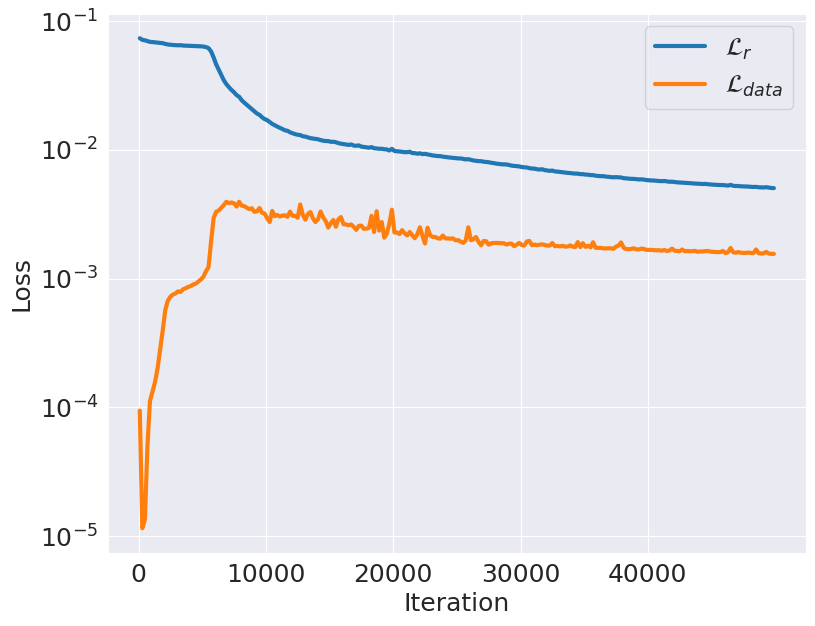

In [22]:
logger = np.load("./logger.npy", allow_pickle=True).item()
k = 2
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(9, 7))
    plt.subplot(111)
    # plt.plot(logger["iter"][::k], logger["loss"][::k], label=r"$L$")
    plt.plot(logger["iter"][::k], logger["loss_v_res"][::k], label=r"$\mathcal{L}_{r}$", linewidth=3)
    plt.plot(logger["iter"][::k], logger["loss_v_data"][::k], label=r"$\mathcal{L}_{data}$", linewidth=3)
    plt.legend()
    plt.xticks([0, 10000, 20000,30000,40000])
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.savefig('loss.png', dpi=100)
    plt.show()

In [28]:
# # 导入模型参数
mu = logger["mu"].cpu()
sigma = logger["sigma"].cpu()

# mu = X_res.mean(dim=0)
# sigma = X_res.std(dim=0)

backbone = MLP(backbone_layers)  # 主干网络
nn_lam = MLP(nn_lam_layers)  # 参数网络 lambda1,2
pinn = PINNNS(backbone, nn_lam, mu, sigma)

model_state = torch.load(os.path.join(model_path, 'pinn_lbfgs.pth'))
pinn.backbone.load_state_dict(model_state['backbone_state'])
pinn.nn_lam.load_state_dict(model_state['nn_lam_state'])
pinn.eval()


# 导入数据
data = scipy.io.loadmat('cylinder_nektar_wake.mat')
X_star = data['X_star'] # 5000,2
t_star = data['t']           # 200,1
U_star = data['U_star'] # 5000,2,200
# 压力p：p(x,y,z,t)
p_star = data['p_star'] # 5000,200

N = X_star.shape[0]
T = t_star.shape[0]

# 平铺
# X,Y分别的坐标
XX = np.tile(X_star[:,0:1], (1,T)) # N,T(5000,200)
YY = np.tile(X_star[:,1:2], (1,T)) # N,T(5000,200)
# 时间t
TT = np.tile(t_star, (1,N)).T # N,T(5000,200)

# 沿x方向的速度：u(x,y,z,t)
UU = U_star[:,0,:] # N,T(5000,200)
# 沿y方向的速度：v(x,y,z,t)
VV = U_star[:,1,:] # N,T(5000,200)
# 压力p：p(x,y,z,t)
PP = p_star # N,T(5000,200)

x = XX.flatten()[:, None]  # NT x 1
y = YY.flatten()[:, None]  # NT x 1
t = TT.flatten()[:, None]  # NT x 1

u = UU.flatten()[:, None]  # NT x 1
v = VV.flatten()[:, None]  # NT x 1
p = PP.flatten()[:, None]  # NT x 1


# # 生成网格
# TT, XX = np.meshgrid(t, x)
# TX = np.concatenate([TT.reshape(-1,1), XX.reshape(-1,1)], axis=1)
# TX = torch.from_numpy(TX).float()
# TX = TX.to(torch.float64)
x = torch.tensor(x)
y = torch.tensor(y)
t = torch.tensor(t)

pinn = pinn.cpu().double()
# pred = pinn.net_u(x,y,t).detach().numpy()
# u_pred = pred[:,[0]]
# v_pred = pred[:,[1]]
# p_pred = pred[:,[2]]
# # u_pred = u_pred.reshape(TT.shape)

# u_error = np.linalg.norm(u_pred - u) / np.linalg.norm(u) 
# print('Relative l2 error of u: {:.3e}'.format(u_error))

forward with normalization, mu=[4.480413913726807, -0.01456326525658369, 9.955120086669922], sigma=[2.046708345413208, 1.173058271408081, 5.741751194000244]


In [29]:
# def f3(t):
#     return - (1 + np.sin(t)/4)
    
# lam1_star = f3(t)
# lam2_star = np.ones_like(t) * 0.1
lam1_star = 1
lam2_star = 0.01

In [30]:
"""计算error"""
# model_state = {'backbone_state': pinn.backbone.state_dict(), 'nn_lam_state': pinn.nn_lam.state_dict()}
# backbone_path = os.path.join(model_path, f'pinn_lbfgs.pth')
# torch.save(model_state, backbone_path)

model_state = torch.load(os.path.join(model_path, 'pinn_adam.pth'))
pinn.backbone.load_state_dict(model_state['backbone_state'])
pinn.nn_lam.load_state_dict(model_state['nn_lam_state'])

print(model_state)

snap = np.array([100])
x_star = X_star[:, 0:1]
y_star = X_star[:, 1:2]
t_star = TT[:,snap]

u_star = U_star[:, 0, snap]
v_star = U_star[:, 1, snap]
p_star = p_star[:,snap]

# Prediction
x_star = torch.tensor(x_star)
y_star = torch.tensor(y_star)
t_star = torch.tensor(t_star)
u_star = torch.tensor(u_star)
v_star = torch.tensor(v_star)
p_star = torch.tensor(p_star)

X = torch.cat([x_star,y_star,t_star], dim=1)
X = torch.tensor(X)
print(t_star)

X_res = pinn.net_NS(X)
u_pred = X_res[2]
v_pred = X_res[3]
p_pred = X_res[4]

# X_res = pinn.net_NS(X)
# u_pred = X_res[2]
# v_pred = X_res[3]
# p_pred = X_res[4]

u_pred =u_pred.detach().cpu().numpy()
v_pred =v_pred.detach().cpu().numpy()
p_pred =p_pred.detach().cpu().numpy()  
lam1_pred = pinn.lam1.detach().cpu().numpy()
lam2_pred = pinn.lam2.detach().cpu().numpy()
print('lam1_pred:',lam1_pred)
print('lam2_pred:',lam2_pred)
print('u_star:',u_star)
print('u_pred:',u_pred)
print('v_star:',v_star)
print('v_pred:',v_pred)
print('p_star:',p_star)
print('p_pred:',p_pred)
# Error
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_v = np.linalg.norm(v_star - v_pred, 2) / np.linalg.norm(v_star, 2)
error_p = np.linalg.norm(p_star - p_pred, 2) / np.linalg.norm(p_star, 2)

error_lambda_1 = np.abs(lam1_pred - lam1_star) /lam1_star * 100
error_lambda_2 = np.abs(lam2_pred - lam2_star) / lam2_star * 100

print('Error u: %e' % (error_u))    
print('Error v: %e' % (error_v))    
print('Error p: %e' % (error_p))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))    

{'iter': 50000, 'backbone_state': OrderedDict([('lam1', tensor([0.9275], device='cuda:0')), ('lam2', tensor([0.0165], device='cuda:0')), ('model.layer0.fc0.weight', tensor([[ 0.2837,  0.2381, -0.7329],
        [-0.0469,  0.1462,  0.8371],
        [ 0.4691,  0.3990, -0.2557],
        [ 0.5653,  0.7351, -0.9811],
        [ 0.5180,  0.1416, -0.0976],
        [-0.1401, -0.7720, -0.0544],
        [ 0.3698,  0.5810, -0.5033],
        [ 0.2258, -0.1398, -0.5261],
        [ 0.3619,  0.0954,  0.1070],
        [ 0.4235,  0.1071, -0.7273],
        [-0.2010,  0.1987,  0.3095],
        [-0.0396, -0.1751,  0.1135],
        [ 0.3371, -0.6525, -0.2565],
        [-0.3379,  0.3103,  0.1751],
        [-0.5366,  0.2467,  0.5267],
        [-0.1906,  0.3885, -0.0432],
        [ 0.4382,  0.5369, -0.9468],
        [-0.7328,  0.0076,  1.5396],
        [-0.1243,  0.6337,  0.2238],
        [-0.0600,  0.6054,  0.0143]], device='cuda:0')), ('model.layer0.fc0.bias', tensor([ 0.4677, -0.7830,  0.4174,  0.5162, -0.12

/tmp/ipykernel_1060054/190852854.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)


In [34]:
X_res[-1]

tensor([[0.6077],
        [0.6072],
        [0.6064],
        ...,
        [0.6218],
        [0.6193],
        [0.6167]], dtype=torch.float64, grad_fn=<ReshapeAliasBackward0>)

(50, 100)
(50, 100)


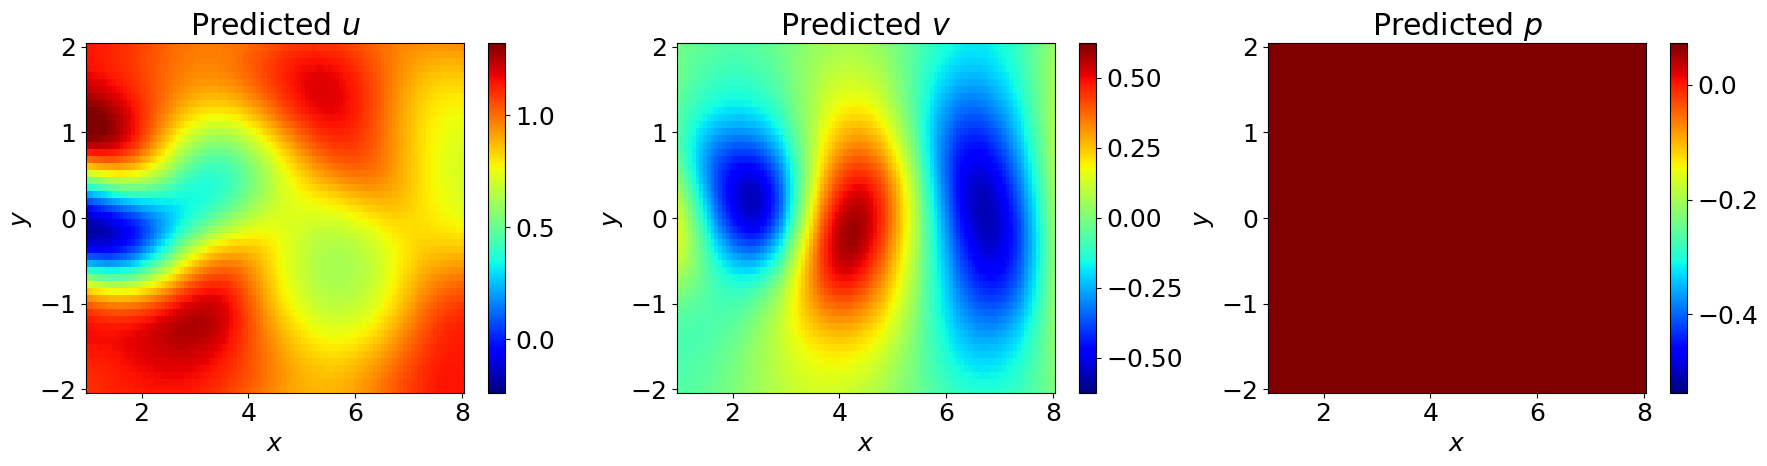

In [36]:
lb = X_star.min(0)
ub = X_star.max(0)
# nn = 1000
x_pic = np.linspace(lb[0], ub[0], 100)
y_pic = np.linspace(lb[1], ub[1], 50)
xx, yy = np.meshgrid(x_pic,y_pic)

print(xx.shape)
print(yy.shape)

# NS_u = U_star[:,0,100]
# NS_v = U_star[:,1,100]
# NS_p = p_star[:,100]

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
# plt.pcolor(xx, yy, u_true.reshape(xx.shape), cmap='jet')
plt.pcolor(xx, yy, u_pred.reshape(xx.shape), cmap='jet')
plt.colorbar()
plt.clim([u.min(),u.max()])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(r'Predicted $u$')
plt.tight_layout()

plt.subplot(1, 3, 2)
# plt.pcolor(xx, yy, u_pred.reshape(xx.shape), cmap='jet')
plt.pcolor(xx, yy, v_pred.reshape(xx.shape), cmap='jet')
plt.colorbar()
plt.clim([v.min(),v.max()])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(r'Predicted $v$')
plt.tight_layout()

plt.subplot(1, 3, 3)
# plt.pcolor(xx, yy, u_pred.reshape(xx.shape), cmap='jet')
plt.pcolor(xx, yy, p_pred.reshape(xx.shape), cmap='jet')
plt.colorbar()
plt.clim([p.min(),p.max()])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(r'Predicted $p$')
plt.tight_layout()

In [ ]:
lb = X_star.min(0)
ub = X_star.max(0)
# nn = 1000
x_pic = np.linspace(lb[0], ub[0], 100)
y_pic = np.linspace(lb[1], ub[1], 50)
xx, yy = np.meshgrid(x_pic,y_pic)

print(xx.shape)
print(yy.shape)

# NS_u = U_star[:,0,100]
# NS_v = U_star[:,1,100]
# NS_p = p_star[:,100]

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
# plt.pcolor(xx, yy, u_true.reshape(xx.shape), cmap='jet')
plt.pcolor(xx, yy, np.abs(u_star.reshape(xx.shape) - u_pred.reshape(xx.shape)), cmap='jet')
plt.colorbar()
plt.clim([u.min(),u.max()])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(r'Absolute error $u$')
plt.tight_layout()

plt.subplot(1, 3, 2)
# plt.pcolor(xx, yy, u_pred.reshape(xx.shape), cmap='jet')
plt.pcolor(xx, yy, np.abs(v_star.reshape(xx.shape) - v_pred.reshape(xx.shape)), cmap='jet')
plt.colorbar()
plt.clim([v.min(),v.max()])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(r'Absolute error $v$')
plt.tight_layout()

plt.subplot(1, 3, 3)
# plt.pcolor(xx, yy, u_pred.reshape(xx.shape), cmap='jet')
plt.pcolor(xx, yy, np.abs(p_star.reshape(xx.shape) - p_pred.reshape(xx.shape)), cmap='jet')
plt.colorbar()
plt.clim([p.min(),p.max()])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(r'Absolute error $p$')
plt.tight_layout()

# 有噪声训练

In [ ]:
dataset = DatasetNS(domain)  # 生成训练数据
X_res, X_data, u_data = dataset.train_data()
X_res = torch.from_numpy(X_res).float().to(device)
X_data = torch.from_numpy(X_data).float().to(device)
u_data = torch.from_numpy(u_data).float().to(device)

noise = 0.01    
# # 噪声产生
u_data = u_data + noise*torch.std(u_data,axis=0)*np.random.randn(u_data.shape[0],u_data.shape[1])

mu = X_res.mean(dim=0)
sigma = X_res.std(dim=0)  # 求样本标准差
print(u_data)


In [ ]:
"""LBFGS训练"""
start_time = time.time()

dataset = DatasetBurgers(domain)  # 生成训练数据
X_res, X_data, u_data = dataset.train_data()
X_res = torch.from_numpy(X_res).float().to(device)
X_data = torch.from_numpy(X_data).float().to(device)
u_data = torch.from_numpy(u_data).float().to(device)

mu = X_res.mean(dim=0)
sigma = X_res.std(dim=0)  # 求样本标准差

backbone_layers = [2] + [20]*8 + [1]
nn_lam_layers = [2] + [20]*8 + [2]

backbone = MLP(backbone_layers)  # 主干网络
nn_lam = MLP(nn_lam_layers)  # 参数网络 lambda1,2
pinn = PINNBurgers(backbone, nn_lam, mu, sigma).to(device)

# model_state = torch.load(os.path.join(model_path, 'pinn_adam.pth'))
# pinn.backbone.load_state_dict(model_state['backbone_state'])
# pinn.nn_lam.load_state_dict(model_state['nn_lam_state'])

optimizer_lbfgs_noise = optim.LBFGS(pinn.backbone.parameters(), max_iter=50000, line_search_fn="strong_wolfe",tolerance_grad=1e-5,tolerance_change=1.0 * np.finfo(float).eps)
optimizer_lbfgs_lam_noise = optim.LBFGS(pinn.nn_lam.parameters(), max_iter=50000, line_search_fn="strong_wolfe",tolerance_grad=1e-5)

loss_log_lbfgs = []
it = 0
with open(train_info_path + 'train_info.txt', 'a') as f:
    f.write('Training by LBFGS:\n')


def closure():
    global it
    pinn.zero_grad()
    loss_res, loss_data = pinn(X_res, X_data, u_data)
    loss = loss_res + loss_data
    loss.backward()
    it = it + 1
    loss_log_lbfgs.append(loss.item())
    if (it + 1) % 100 == 0:
        info = f'Iter # {it + 1:4d}\ttime:{time.time() - start_time:.1f}\t' + f'loss:{loss.item():.2e}, loss_r:{loss_res.item():.2e}, loss_d:{loss_data.item():2e}'
        with open(train_info_path + 'train_info.txt', 'a') as f:
            f.write(info + '\n')
        print(info)
    return loss

optimizer_lbfgs_noise.step(closure)
optimizer_lbfgs_lam_noise.step(closure)

model_state = {'backbone_state': pinn.backbone.state_dict(), 'nn_lam_state': pinn.nn_lam.state_dict()}
backbone_path = os.path.join(model_path, f'pinn_lbfgs_noise.pth')
torch.save(model_state, backbone_path)

In [ ]:
it

In [ ]:
model_state

## 结果可视化

In [ ]:
mu = X_res.mean(dim=0)
sigma = X_res.std(dim=0)

backbone = MLP(backbone_layers)  # 主干网络
nn_lam = MLP(nn_lam_layers)  # 参数网络 lambda1,2
pinn = PINNBurgers(backbone, nn_lam, mu, sigma)

model_state = torch.load(os.path.join(model_path, 'pinn_lbfgs_noise.pth'))
pinn.backbone.load_state_dict(model_state['backbone_state'])
pinn.nn_lam.load_state_dict(model_state['nn_lam_state'])
pinn.eval()

# 导入数据
data = scipy.io.loadmat('cylinder_nektar_wake.mat')
u_star = data['usol']
t = data['t'].flatten()
x = data['x'].flatten()
# 生成网格
TT, XX = np.meshgrid(t, x)
TX = np.concatenate([TT.reshape(-1,1), XX.reshape(-1,1)], axis=1)
TX = torch.from_numpy(TX).float()
TX = TX.to(torch.float64)

pinn = pinn.cpu().double()
u_pred = pinn.net_u(TX).detach().numpy()
u_pred = u_pred.reshape(TT.shape)

u_error = np.linalg.norm(u_pred - u_star) / np.linalg.norm(u_star) 
print('Relative l2 error of u: {:.3e}'.format(u_error))

In [ ]:
lam1_star = 1
lam2_star = 0.01/(np.pi)

lam1_pred = pinn.lam1.detach().cpu().numpy()
lam2_pred = pinn.lam2.detach().cpu().numpy()
print('lam1_pred:',lam1_pred)
print('lam1_pred:',lam2_pred)

# lam1_pred = lam1_pred.detach().numpy()
# lam1_pred = lam1_pred.reshape(t.shape)
lam1_error = np.linalg.norm(lam1_pred - lam1_star) / np.linalg.norm(lam1_star)

# lam2_pred = lam2_pred.detach().numpy()
# lam2_pred = lam2_pred.reshape(t.shape)
lam2_error = np.linalg.norm(lam2_pred - lam2_star) / np.linalg.norm(lam2_star)

print('Relative l2 error of lam1: {:.3e}'.format(lam1_error))
print('Relative l2 error of lam2: {:.3e}'.format(lam2_error))

In [ ]:
fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(1, 3)

plt.subplot(1,3,1)
# cax1 = axes[0].pcolor(TT, XX, u_star, cmap='jet')
cax1 = plt.pcolor(TT, XX, u_star, cmap='jet')
fig.colorbar(cax1)
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].set_title(r'Reference $u(t,x)$')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([-1, 1])
axes[0].set_xticks(np.arange(0, 1.1, 2.))
axes[0].set_yticks(np.arange(-1, 1.1, 4.))
axes[0].set_aspect(1./axes[0].get_data_ratio())

plt.subplot(1,3,2)
cax2 = plt.pcolor(TT, XX, u_pred, cmap='jet')
fig.colorbar(cax2)
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')
axes[1].set_title(r'Predicted $u(t,x)$')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([-1, 1])
axes[1].set_xticks(np.arange(0, 1.1, 2.))
axes[1].set_yticks(np.arange(-1, 1.1, 4.))
axes[1].set_aspect(1./axes[1].get_data_ratio())

plt.subplot(1,3,3)
cax3 = plt.pcolor(TT, XX, np.abs(u_star - u_pred), cmap='jet')
fig.colorbar(cax3)
axes[2].set_xlabel('$x_1$')
axes[2].set_ylabel('$x_2$')
axes[2].set_title('Absolute error')
axes[2].set_xlim([0, 1])
axes[2].set_ylim([-1, 1])
axes[2].set_xticks(np.arange(0, 1.1, 2.))
axes[2].set_yticks(np.arange(-1, 1.1, 4.))
axes[2].set_aspect(1./axes[2].get_data_ratio())

plt.tight_layout()
plt.savefig('Burgers_result.png', dpi=100, bbox_inches='tight')
plt.show()